In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [3]:
block = 0
trial = 13

# -----------------------------------------
N_trials = exp['N_trials']
screen_width_px = exp['screen_width_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']
# -----------------------------------------

trial_data = trial + N_trials*block

time = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
# [starttime, endtime, duration, startx, starty, endx, endy]
saccades = data[trial_data]['events']['Esac']
t_0 = time[0]

DATA_x = data[trial_data]['x']
data_x = DATA_x-(DATA_x[StimulusOf-t_0])
#data_x = DATA_x-(exp['screen_width_px']/2)

bino = p[trial, block, 0]

start = TargetOn
start1 = TargetOn-t_0

In [4]:
def deco(axs) :
    axs.axvspan(StimulusOn-start, StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(StimulusOf-start, TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(TargetOn-start, TargetOff-start, color='k', alpha=0.15)
    for s in range(len(saccades)) :
        axs.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

In [5]:
from ANEMO import ANEMO

In [6]:
def position2(x, bino, start_anti, v_anti, latence, tau, maxi, nan=False, do_numpy=True):
    
    #gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
    ms = 1000
    v_anti = (v_anti/1000) #/ms # pour passer de sec à ms
    maxi = maxi /ms
    
    speed = ANEMO.fct_exponentiel(x, bino, start_anti, v_anti, latence, tau, maxi)
    pos = np.cumsum(speed)

    if nan == True :
        avant, apres =  5, 10 #15
        for sacc in saccades :
            if sacc[0]-t_0 > int(latence) :
                # [starttime, endtime, duration, startx, starty, endx, endy]
                #pos[int(sacc[1]-t_0+1):] += (sacc[5]-sacc[3])/ exp['px_per_deg'] - np.sum(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]
                pos[int(sacc[0]-t_0)-avant:int(sacc[1]-t_0)+apres] = np.nan 
                pos[int(sacc[1]-t_0)+apres:] += ((data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])/exp['px_per_deg']) - np.mean(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]

 
    return pos

In [7]:
data = np.copy(data_x)
  
avant, apres =  5, 10 #15
for s in range(len(saccades)) :
    if saccades[s][1]-t_0+apres <= (len(time)) :
        for x_data in np.arange((saccades[s][0]-t_0-avant), (saccades[s][1]-t_0+apres)) :
            data[x_data] = np.nan
    else :
        for x_data in np.arange((saccades[s][0]-t_0-avant), (len(time))) :
            data[x_data] = np.nan
            
# data2 = np.copy(data)           
data3 = np.copy(data)
a = 0

for sacc in saccades :
    # [starttime, endtime, duration, startx, starty, endx, endy]
    #pos[int(sacc[1]-t_0+1):] += (sacc[5]-sacc[3])/ exp['px_per_deg'] - np.sum(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]
    a = (data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])
    b = ((data_x[int(sacc[0]-t_0)-avant-1]-data_x[int(sacc[0]-t_0)-avant-11])/10)
    data3[int(sacc[1]-t_0+apres):] += - a + ((sacc[1]-t_0+apres)-(sacc[0]-t_0-avant)) * b
            
data3 = data3 - data3[StimulusOf-t_0]

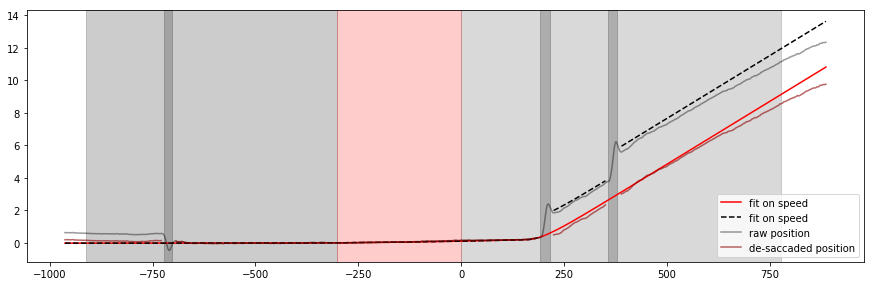

In [8]:
fig_width = 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)

a = position2(np.arange(len(time)), bino, param['start_anti'][block][trial]+start1,
             param['v_anti'][block][trial], param['latence'][block][trial]+start1,
             param['tau'][block][trial], param['maxi'][block][trial]) 
axs.plot(time-start, a-np.ones(len(a))*(a[StimulusOf-t_0]), c='r', label='fit on speed')

b = position2(np.arange(len(time)), bino, param['start_anti'][block][trial]+start1,
             param['v_anti'][block][trial], param['latence'][block][trial]+start1,
             param['tau'][block][trial], param['maxi'][block][trial], nan=True)
axs.plot(time-start, b-np.ones(len(b))*(b[StimulusOf-t_0]), '--k', label='fit on speed')


axs.plot(time-start, data_x / exp['px_per_deg'], color='k', alpha=0.4, label='raw position')
axs.plot(time-start, data3 / exp['px_per_deg'] , color='darkred', alpha=0.6, label='de-saccaded position')
axs.legend();

# doing the fit

In [9]:
def Fit_position(velocity_x, trackertime, bino, param_fit=None, TargetOn=TargetOn,
                 StimulusOf=StimulusOf, saccades=saccades, sup=False, time_sup=-280, step=2,
                 nan=True) :

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,1.,40], 'v_anti':[0.,-100.,100.],
                   'latence':[TargetOn-t_0+100,TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]} #'v_anti':[0.,-40.,40.]

    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0))
        if stop_latence==[] :
            stop_latence.append(len(trackertime))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        velocity_x = velocity_x[:time_sup]
        trackertime = trackertime[:time_sup]
    
    model = Model(position2)

    params = Parameters()

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('nan', value=nan, vary=False)
    params.add('bino', value=bino, vary=False)
    
    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vary)

    if step == 1 :
        result_deg = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        result_deg = model.fit(velocity_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg


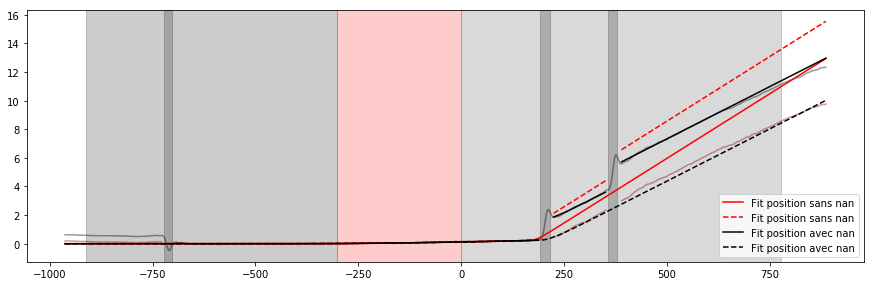

In [10]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)
#axs.plot(time-start, data_x, color='k', alpha=0.6)

#gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
data_2 = np.copy(data3) #data_x)
data_2 /= exp['px_per_deg']

data_1 = np.copy(data_x)
data_1 /= exp['px_per_deg']

axs.plot(time-start, data_1, color='k', alpha=0.4)
axs.plot(time-start, data_2 , color='darkred', alpha=0.4)


a = Fit_position(data_2,time, bino,step=1, sup=True, time_sup=-280, nan=False)
b = position2(np.arange(len(time)), bino, a.values['start_anti'], a.values['v_anti'], a.values['latence'], a.values['tau'], a.values['maxi'])
f = position2(np.arange(len(time)), bino, a.values['start_anti'], a.values['v_anti'], a.values['latence'],
              a.values['tau'], a.values['maxi'], nan=True)
axs.plot(time-start, b , c='r', label='Fit position sans nan')
axs.plot(time-start, f , '--r', label='Fit position sans nan')

c = Fit_position(data_1,time, bino,step=1, sup=True, time_sup=-280, nan=True)
d = position2(np.arange(len(time)), bino, c.values['start_anti'], c.values['v_anti'],
             c.values['latence'], c.values['tau'], c.values['maxi'], nan=True)
e = position2(np.arange(len(time)), bino, c.values['start_anti'], c.values['v_anti'],
             c.values['latence'], c.values['tau'], c.values['maxi'], nan=False)

axs.plot(time-start, d , 'k', label='Fit position avec nan')
axs.plot(time-start, e , '--k', label='Fit position avec nan')
axs.legend();

In [11]:
print('start_anti : %0.3f    a -> %0.3f, c -> %0.3f'%(param['start_anti'][block][trial], a.values['start_anti']-start1, c.values['start_anti']-start1), 
      '\nv_anti : %0.3f    a -> %0.3f, c -> %0.3f'%(param['v_anti'][block][trial], a.values['v_anti'], c.values['v_anti']), 
      '\nlatence : %0.3f    a -> %0.3f, c -> %0.3f'%(param['latence'][block][trial], a.values['latence']-start1, c.values['latence']-start1),
      '\ntau : %0.3f    a -> %0.3f, c -> %0.3f'%(param['tau'][block][trial], a.values['tau'], c.values['tau']),
      '\nmaxi : %0.3f    a -> %0.3f, c -> %0.3f'%(param['maxi'][block][trial], a.values['maxi'], c.values['maxi']))

start_anti : -501.000    a -> -448.039, c -> -460.869 
v_anti : 0.978    a -> 1.226, c -> 1.145 
latence : 161.143    a -> 171.276, c -> 192.000 
tau : 41.617    a -> 13.002, c -> 27.417 
maxi : 14.820    a -> 17.301, c -> 13.853


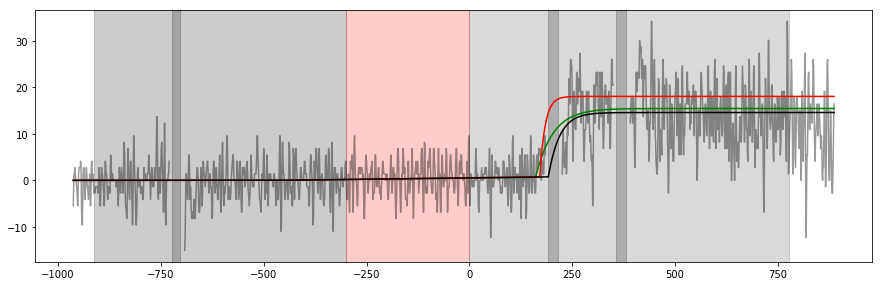

In [12]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)

axs.plot(time-start, ANEMO.velocity_deg(data3, exp['px_per_deg']), color='k', alpha=0.4)

exp0 = ANEMO.fct_exponentiel(np.arange(len(time)), bino, param['start_anti'][block][trial]+TargetOn-t_0, param['v_anti'][block][trial],
                          param['latence'][block][trial]+TargetOn-t_0, param['tau'][block][trial], param['maxi'][block][trial])
exp1 = ANEMO.fct_exponentiel(np.arange(len(time)), bino, a.values['start_anti'], a.values['v_anti'],
                          a.values['latence'], a.values['tau'], a.values['maxi'])
exp2 = ANEMO.fct_exponentiel(np.arange(len(time)), bino, c.values['start_anti'], c.values['v_anti'],
                          c.values['latence'], c.values['tau'], c.values['maxi'])


axs.plot(time-start, exp0 , c='g')
axs.plot(time-start, exp1 , c='r')
axs.plot(time-start, exp2 , c='k');